<b>Social Network Advertisments Bandit Problems</b>

In this notebook, I'm trying to create a simulation about a real-world Bernoulli trial. I'm going to figure out how different age groups react to social net work ads --- click a link or not click.

Age 10 ~ 19: 0.2<br>
Age 20 ~ 29: 0.6<br>
Age 30 ~ 39: 0.3<br>
Age 40 ~ 49: 0.4<br>
Age 50 ~ 59: 0.8<br>

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

In [62]:
stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    if (self.arm_count>5):
        self.thetas = np.random.uniform(0,1,self.arm_count)
    else:
        self.thetas = np.asarray([0.2,0.6,0.3,0.4,0.88])
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [63]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [64]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [65]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [66]:
class RandomSampling():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        
    @staticmethod
    def name():
        return 'random'
    
    def get_action(self):
        """ Generating random samples between 0 and 1 using uniform distribution"""
        theta = np.random.uniform(0,1,self.arm_count)
        return theta.argmax()
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

In [67]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

<b>Optimize your Bandit Problem using Thompson Sampling, e-greedy, UBC, and random sampling.</b>

<b>Answer the following questions </b>

<b>1. Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important.</b> 

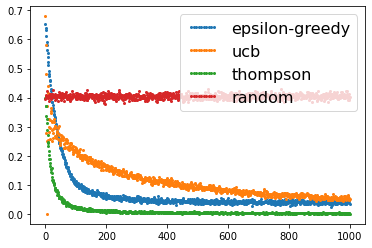

In [68]:
# Experoment 1
arm_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

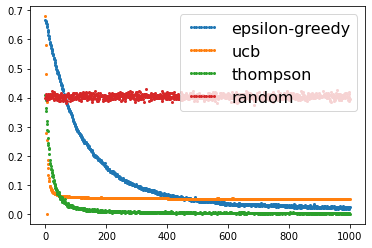

In [69]:
# Experiment 2
arm_count = 5 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

<img src="files/1.png">

<img src="files/3.png">

Alpha and beta are important for Thompson Sampling.<br>
Epsilon is important for e-greedy.<br>
The c is important for UBC.<br>
Random Sampling doesn't have important hyperparameters.

<b>2. How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why.</b>

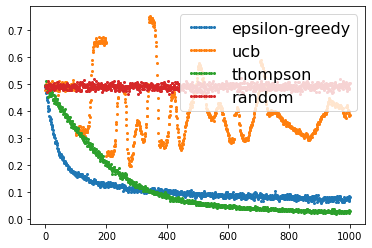

In [70]:
# Experiment 3
arm_count = 100 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

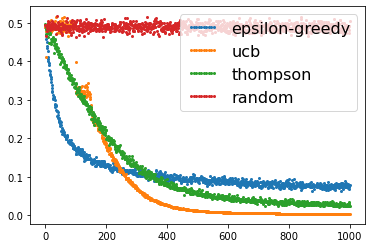

In [71]:
# Experiment 4
arm_count = 100 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

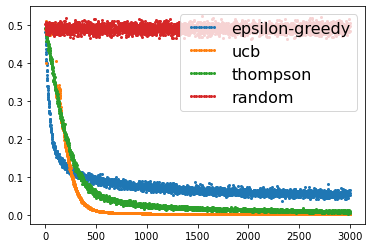

In [72]:
# Experiment 5
arm_count = 100 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

In this setting, we increase the number of actions from 5 to 100, leaving the other parameters equal to our baseline.<br> 
The epsilon-greedy agent barely budges in its learning pattern when compared to the baseline. <br>
The Thompson agent very slowly, but surely, decreases regret to eventually outperform epsilon-greedy around step 700, another vote of confidence for Thompson. <br>
On the other hand, UCB is drastically unstable and diverges.<br>
Random Sampling, however, is not affected by the action space.

<b>3. How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why.</b>

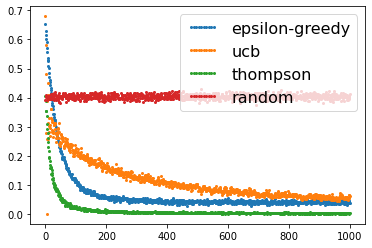

In [73]:
# Experiment 6
arm_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

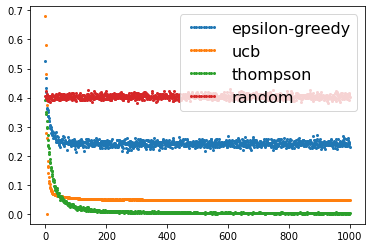

In [74]:
# Experiment 7
arm_count = 5 # number of arms in bandit
epsilon = 0.6
ucb_c = 0.1
stationary=False
experiment(arm_count)

We now resetrWe now reset our parameters to the baseline settings. However, we now set the environment to being non-stationary.<br>
While the epsilon-greedy and Thompson's regret quickly decrease, on average they increase over time.<br>
On the other hand, UCB reacts much more quickly to the bandit non-stationarity, and actually continues to improve in regret over time, no doubt due to its higher emphasis on exploration.<br>
Random Sampling, however, is still not affacted by stationary or non-stationary.

<b>4. When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff.</b>

Thompson Sampling stops exploring when the simulation is completed while choosing the action that maximizes the expected reward with respect to a randomly drawn belief.<br>
Epsilon-greedy where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.<br>
UBC stops exploring when the simulation is completed.<br>
Random Sampling explores everytime.<br>
The exploration/exploitation trade-off (EE trade-off) describes how, when faced with several competing alternatives, decision-makers must often choose between a known good alternative (exploitation) and one or more unknown but potentially more rewarding alternatives (exploration).

<b>5. How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer.</b>

Thompson Sampling will always remember the past actions by changing alpha and beta.<br>
Epsilon-greedy remembers the past actions when changing epsilon.<br>
UBC remember the result of the past actions by changing the parameters.<br>
Random Sampling doesn't remember the past actions because choosing age group is random.

<b>6. Thompson Sampling with non-Beta distribution. Modify the Thompson Sampling to run with a different distribution.</b>

In [78]:
import math
class ThompsonNormal():
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.mean = np.zeros(self.arm_count)
    self.std = np.zeros(self.arm_count)
    self.n = np.zeros(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.n[arm]+=1
    old_mean = self.mean[arm]
    new_mean = (self.mean[arm]*(self.n[arm]-1) + reward)/self.n[arm]
    self.mean[arm] = new_mean

    old_var = np.power(self.std[arm],2)
    if((self.n[arm]-1)!=0):
      new_var = ((self.n[arm]-2)/(self.n[arm]-1))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    else:
      new_var = ((self.n[arm]-2))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    self.std[arm] = math.sqrt(new_var)

  @staticmethod
  def name():
    return 'thompson-normal'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.normal(self.mean, self.std)
    return theta.argmax()

In [79]:
def experiment_compare_thompson(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [BernThompson, ThompsonNormal]
 
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

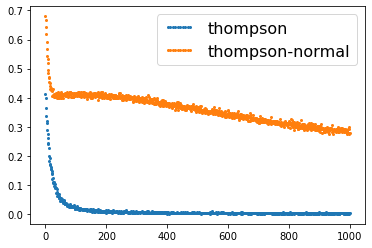

In [80]:
arm_count = 5 # number of arms in bandit
stationary=True
experiment_compare_thompson(arm_count)

<b>7. What code is yours and what have you adapted?</b>

I created five bandits that represent different age groups's willingness to click on ads and adapted to the code.<br>
Worte the random sampling code.
All experiments are modified to each questions.

<b>References</b><br>
[1] https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb<br>
[2] Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, and Ian Osband. "A Tutorial on Thompson Sampling." arXiv preprint arXiv:1707.02038 (2017).<br>
[3] Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Vol. 1, no. 1. Cambridge: MIT press, 1998.<br>
[4] https://lilianweng.github.io/posts/2018-01-23-multi-armed-bandit/<br>
[5] https://arxiv.org/abs/1707.02038<br>
[6] https://colab.research.google.com/drive/1gdR7k7jtSRqYnPNHcbAKdIjGRjQXpfnA

<b>8. Did I explain my licensing clearly?</b>

Copyright (c) 2022 Junyang Luo.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.